# Predicting Apartment Renting Prices in Santiago - Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import re

from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 
import seaborn as sns

matplotlib.rcParams["figure.figsize"] = (8,5)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Data Load: load csv into a dataframe

In [2]:
df = pd.read_csv("RENT_APARTMENT_RM_clean.csv")
print(df.shape)
df

(4808, 7)


,Surface_total,Surface_usable,Bedrooms,Bathrooms,Location,URL,Price
0,57.0,57.0,2.0,1.0,Cerrillos,https://www.portalinmobiliario.com/MLC-9799489...,350000.0
1,90.0,80.0,3.0,2.0,Cerrillos,https://www.portalinmobiliario.com/MLC-9751095...,600000.0
2,80.0,80.0,3.0,1.0,Cerrillos,https://www.portalinmobiliario.com/MLC-9801789...,450000.0
3,57.0,57.0,3.0,1.0,Cerro Navia,https://www.portalinmobiliario.com/MLC-9796174...,450000.0
4,137.0,120.0,3.0,2.0,Colina,https://www.portalinmobiliario.com/MLC-9776447...,1079369.0
...,...,...,...,...,...,...,...
4803,235.0,220.0,3.0,4.0,Vitacura,https://www.portalinmobiliario.com/MLC-9678405...,2000000.0
4804,119.0,105.0,3.0,3.0,Vitacura,https://www.portalinmobiliario.com/MLC-9758474...,1100000.0
4805,182.0,144.0,3.0,3.0,Vitacura,https://www.portalinmobiliario.com/MLC-9751390...,1460322.0
4806,120.0,103.0,3.0,3.0,Vitacura,https://www.portalinmobiliario.com/MLC-9701371...,1269845.0


In [3]:
df.describe()

,Surface_total,Surface_usable,Bedrooms,Bathrooms,Price
count,4808.000000,4808.000000,4808.000000,4808.000000,4.808000e+03
mean,140.971714,130.126456,2.234401,2.066348,5.128123e+06
std,1964.234850,2023.436156,1.069932,3.609842,1.804996e+08
min,1.000000,1.000000,1.000000,1.000000,1.900000e+05
25%,44.000000,41.000000,1.000000,1.000000,3.968098e+05
50%,68.000000,64.000000,2.000000,2.000000,6.500000e+05
75%,140.000000,124.000000,3.000000,3.000000,1.393972e+06
max,135025.000000,135000.000000,16.000000,240.000000,8.888918e+09


## Distribution of feature values

In [4]:
df.columns.values

array(['Surface_total', 'Surface_usable', 'Bedrooms', 'Bathrooms',
       'Location', 'URL', 'Price'], dtype=object)

### Surface (square meters)

(-50.0, 1100.0)

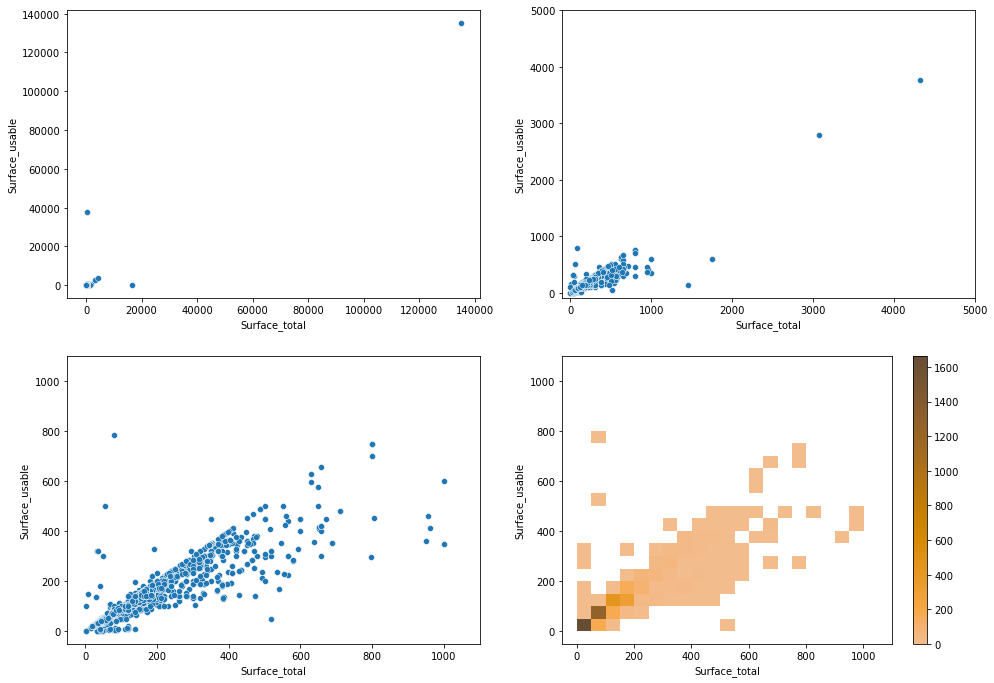

In [5]:
threshold_surface = 1000
df2 = df[(df["Surface_usable"] < threshold_surface) & (df["Surface_total"] < threshold_surface)]

nrows, ncols = 2, 2

fig = plt.figure(figsize=(7.*ncols, 5.*nrows))
plt.subplots_adjust(wspace=.2, hspace=.2, bottom=0, left=0)
ax = []

ax = fig.add_subplot(nrows, ncols, 1)
sns.scatterplot(data=df, x="Surface_total", y="Surface_usable", ax=ax)

ax = fig.add_subplot(nrows, ncols, 2)
sns.scatterplot(data=df, x="Surface_total", y="Surface_usable", ax=ax)
ax.set_xlim(-100, 5000)
ax.set_ylim(-100, 5000)

ax = fig.add_subplot(nrows, ncols, 3)
sns.scatterplot(data=df, x="Surface_total", y="Surface_usable", ax=ax)
ax.set_xlim(-50, 1100)
ax.set_ylim(-50, 1100)

ax = fig.add_subplot(nrows, ncols, 4)
# sns.displot(data=df, x="Surface_total", y="Surface_usable", binwidth=(50, 50))
sns.histplot(data=df2, x="Surface_total", y="Surface_usable", binwidth=(50, 50), color='orange', cbar=True, ax=ax)
# sns.heatmap(data=df2[["Surface_total", "Surface_usable"]])
ax.set_xlim(-50, 1100)
ax.set_ylim(-50, 1100)


We can extract some observations and conclusions from the plots above:
- There are some outlier values present in both *Surface_usable* and *Surface_total* features. These outliers are mostly concentrated in values above 600-1000 square meters, depending on the threshold we use to classify them as outliers.

- In the range of values below 1000 square meters, most of *Surface_total* values are higher than their corresponding *Surface_usable* values, as we can see from the fact that there is larger amount of scatter (higher density in the 2D histogram) of values below the identity line (y=x). *Surface_total* values most likely are considering additional dependencies in the properties (grilling or gardening area, courtyard), which the renters may have accessed to. To avoid including this extra property area, we will stick to the *Surface_usable* values and eventually remove *Surface_total* feature.

- There is a subset of *Surface_usable* values which are suspiciously higher than their corresponding *Surface_total* values. These values are dots in the scatter plots in the range *Surface_total* < 100 and *Surface_usable* > 100. 

Next we will consider only listings with *Surface_usable* below a threshold of 600 square meters, because apartments with larger areas are much less common so it is more likely that their sizes could have been misreported. 
We will also further examine the difference between values of *Surface_usable* and *Surface_total* features, in order to remove possible additional outliers.

In [6]:
df3 = df[df["Surface_usable"] <= 600]
df3['Surface_difference'] = df3.apply(
    lambda row: row.Surface_total - row.Surface_usable, axis=1
)

print(df3.shape)
df3.sort_values(by=['Surface_difference'], ascending=True).head(20)

(4797, 8)


/tmp/ipykernel_12267/1025109694.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Surface_difference'] = df3.apply(


,Surface_total,Surface_usable,Bedrooms,Bathrooms,Location,URL,Price,Surface_difference
423,54.0,501.0,2.0,2.0,La Cisterna,https://www.portalinmobiliario.com/MLC-9327727...,458691.0,-447.0
3044,33.0,321.0,1.0,1.0,San Joaquin,https://www.portalinmobiliario.com/MLC-9804785...,340000.0,-288.0
3293,36.0,321.0,1.0,1.0,San Miguel,https://www.portalinmobiliario.com/MLC-9765724...,330000.0,-285.0
810,50.0,300.0,3.0,4.0,Las Condes,https://www.portalinmobiliario.com/MLC-9792138...,3274297.0,-250.0
1481,8.0,150.0,3.0,4.0,Las Condes,https://www.portalinmobiliario.com/MLC-9709421...,2500000.0,-142.0
4421,40.0,180.0,4.0,4.0,Vitacura,https://www.portalinmobiliario.com/MLC-9801987...,2400000.0,-140.0
1150,191.0,330.0,4.0,3.0,Las Condes,https://www.portalinmobiliario.com/MLC-9564414...,2380961.0,-139.0
1421,30.0,138.0,3.0,2.0,Las Condes,https://www.portalinmobiliario.com/MLC-9694727...,2857153.0,-108.0
1317,30.0,138.0,3.0,2.0,Las Condes,https://www.portalinmobiliario.com/MLC-9612971...,2857153.0,-108.0
1697,350.0,450.0,4.0,4.0,Las Condes,https://www.portalinmobiliario.com/MLC-9756789...,2700000.0,-100.0


The difference between values of *Surface_usable* and *Surface_total* features is reported in the new feature *Surface_difference*.

By sorting this feature in ascending order, we can see on top of the column values where *Surface_usable* >> *Surface_total*. These points correspond to the subset of suspicious values which we observed before; dots in the scatter plots in the range *Surface_total* < 100 and *Surface_usable* > 100.
To be in the safe side, we will remove from the analysis data where *Surface_difference* < -50, since these points are potential additional outliers.

In [7]:
df4 = df3[df3["Surface_difference"] > -50]
print(df4.shape)
df4.sort_values(by=['Surface_difference'], ascending=True).head(20)

(4785, 8)


,Surface_total,Surface_usable,Bedrooms,Bathrooms,Location,URL,Price,Surface_difference
2447,70.0,110.0,2.0,2.0,Nunoa,https://www.portalinmobiliario.com/MLC-9782535...,850000.0,-40.0
4778,200.0,235.0,4.0,3.0,Vitacura,https://www.portalinmobiliario.com/MLC-9742071...,2950000.0,-35.0
4775,185.0,220.0,5.0,3.0,Vitacura,https://www.portalinmobiliario.com/MLC-9695407...,2950000.0,-35.0
651,70.0,95.0,3.0,2.0,La Reina,https://www.portalinmobiliario.com/MLC-9794487...,550000.0,-25.0
1546,295.0,320.0,3.0,4.0,Las Condes,https://www.portalinmobiliario.com/MLC-9782953...,2857153.0,-25.0
4686,125.0,150.0,3.0,2.0,Vitacura,https://www.portalinmobiliario.com/MLC-9804853...,1269845.0,-25.0
3787,95.0,115.0,3.0,2.0,Santiago,https://www.portalinmobiliario.com/MLC-9755215...,620000.0,-20.0
4102,80.0,100.0,4.0,2.0,Santiago,https://www.portalinmobiliario.com/MLC-9782975...,550000.0,-20.0
4786,120.0,140.0,3.0,3.0,Vitacura,https://www.portalinmobiliario.com/MLC-9693648...,1550000.0,-20.0
1871,180.0,200.0,4.0,4.0,Lo Barnechea,https://www.portalinmobiliario.com/MLC-9792130...,2501596.0,-20.0


Let's plot how the relationship between *Surface_usable* and *Surface_total* look before and after removing the additional outliers.

We also plot the new distribution of *Surface_usable* values after removing outliers above the threshold of 600 square meters.

Text(0.5, 1.0, 'After removing outliers')

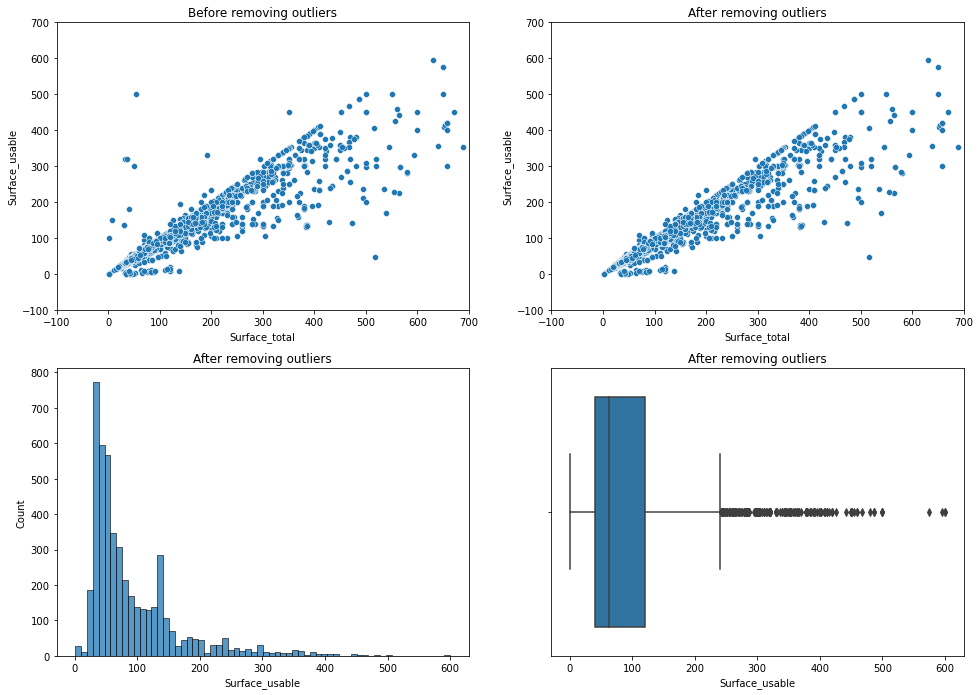

In [8]:
nrows, ncols = 2, 2

fig = plt.figure(figsize=(7.*ncols, 5.*nrows))
plt.subplots_adjust(wspace=.2, hspace=.2, bottom=0, left=0)
ax = []

ax = fig.add_subplot(nrows, ncols, 1)
sns.scatterplot(data=df3, x="Surface_total", y="Surface_usable", ax=ax)
ax.set_title('Before removing outliers')
ax.set_xlim(-100, 700)
ax.set_ylim(-100, 700)

ax = fig.add_subplot(nrows, ncols, 2)
sns.scatterplot(data=df4, x="Surface_total", y="Surface_usable", ax=ax)
ax.set_title('After removing outliers')
ax.set_xlim(-100, 700)
ax.set_ylim(-100, 700)

ax = fig.add_subplot(nrows, ncols, 3)
sns.histplot(data=df4, x="Surface_usable")
ax.set_title('After removing outliers')

ax = fig.add_subplot(nrows, ncols, 4)
sns.boxplot(x=df4["Surface_usable"])
ax.set_title('After removing outliers')

### Rooms

Let's explore now the values of the discrete features *Bedrooms* and *Bathrooms*, and its relationship.

In [9]:
df4.Bedrooms.value_counts(ascending=False)

2.0     1576
1.0     1404
3.0     1210
4.0      523
5.0       58
6.0        9
7.0        3
8.0        1
16.0       1
Name: Bedrooms, dtype: int64

In [10]:
df4.Bathrooms.value_counts(ascending=False)

1.0      1883
2.0      1619
3.0       782
4.0       409
5.0        68
6.0        13
7.0         3
8.0         2
10.0        2
12.0        1
240.0       1
9.0         1
21.0        1
Name: Bathrooms, dtype: int64

(-1.0, 20.0)

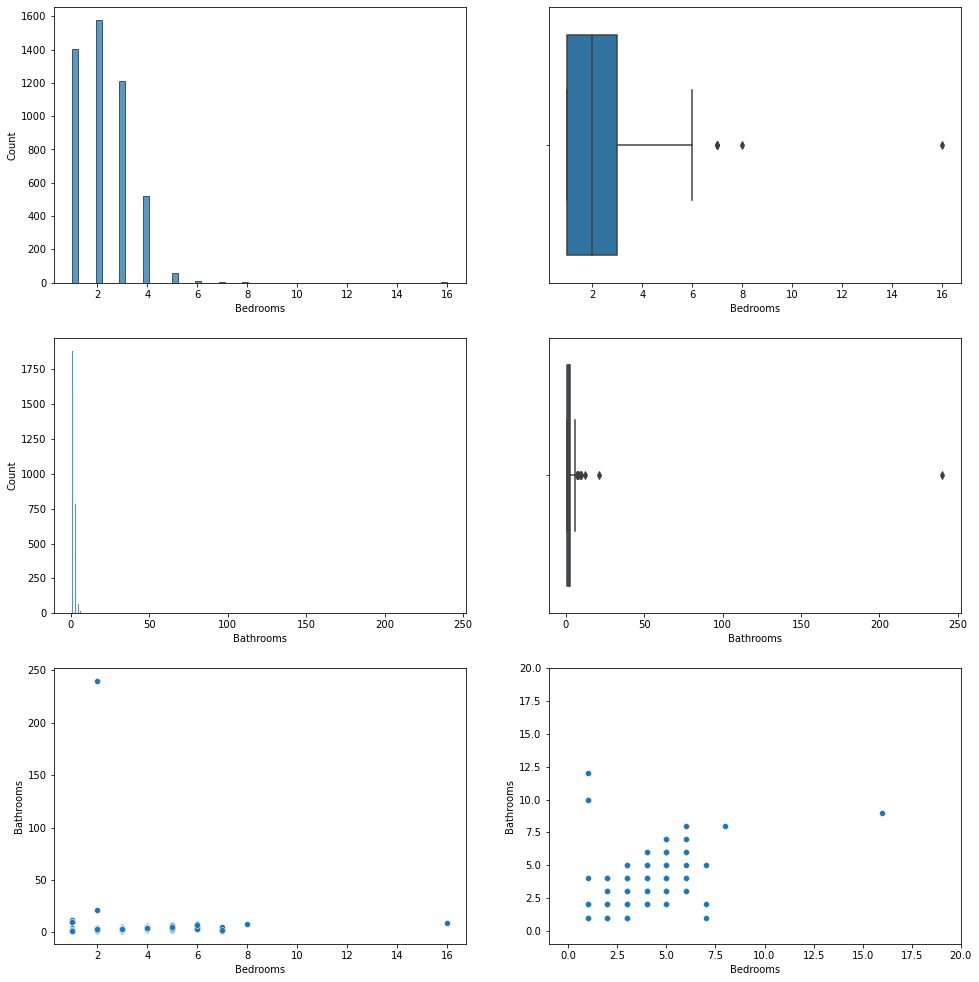

In [11]:
nrows, ncols = 4, 2

fig = plt.figure(figsize=(7.*ncols, 5.*nrows))
plt.subplots_adjust(wspace=.2, hspace=.2, bottom=0, left=0)
ax = []

ax = fig.add_subplot(nrows, ncols, 1)
sns.histplot(data=df4, x="Bedrooms")

ax = fig.add_subplot(nrows, ncols, 2)
sns.boxplot(x=df4["Bedrooms"])

ax = fig.add_subplot(nrows, ncols, 3)
sns.histplot(data=df4, x="Bathrooms")

ax = fig.add_subplot(nrows, ncols, 4)
sns.boxplot(x=df4["Bathrooms"])

ax = fig.add_subplot(nrows, ncols, 5)
sns.scatterplot(data=df4, x="Bedrooms", y="Bathrooms", ax=ax)

ax = fig.add_subplot(nrows, ncols, 6)
sns.scatterplot(data=df4, x="Bedrooms", y="Bathrooms", ax=ax)
ax.set_xlim(-1, 20)
ax.set_ylim(-1, 20)

In [12]:
df5 = df4[(df4["Bedrooms"] >= 10) | (df4["Bathrooms"] >= 10)]
print(df5.shape)
df5.sort_values(by=['Bathrooms'], ascending=False)

(6, 8)


,Surface_total,Surface_usable,Bedrooms,Bathrooms,Location,URL,Price,Surface_difference
3629,85.0,40.0,2.0,240.0,Santiago,https://www.portalinmobiliario.com/MLC-9798227...,4.200000e+05,45.0
4435,120.0,88.0,2.0,21.0,Vitacura,https://www.portalinmobiliario.com/MLC-9805565...,1.500000e+06,32.0
2892,12.0,12.0,1.0,12.0,Providencia,https://www.portalinmobiliario.com/MLC-9704752...,8.792187e+09,0.0
3805,28.0,28.0,1.0,10.0,Santiago,https://www.portalinmobiliario.com/MLC-9774447...,2.800000e+05,0.0
4322,32.0,32.0,1.0,10.0,Santiago,https://www.portalinmobiliario.com/MLC-9752650...,2.900000e+05,0.0
3908,1000.0,600.0,16.0,9.0,Santiago,https://www.portalinmobiliario.com/MLC-9523386...,5.714304e+06,400.0


From the plots and dataframe above, there are a few points that seem suspicious: apartments with considerably large number of *Bathrooms* (>10) and only 1 or 2 *Bedrooms*, and an apartment with 16 *Bedrooms* and 9 *Bathrooms*; (2).

The listings with at least 10 *Bathrooms* and only 1 or 2 *Bedrooms* are most likely outliers; it's simply unrealistic imagine an apartment with such discrepancy. Therefore we will remove this data point. 

The remaining potential outlier, however, conceivable represents actual data of an apartment having 16 *Bedrooms* and 9 *Bathrooms*, especially considering its reported usable living area (600 square meters) and its renting preis (5714304 CLP). Consequently, we will keep this data point.

In [13]:
df6 = df4[df4["Bathrooms"] < 10]
print(df6.shape)
df6.sort_values(by=['Bathrooms'], ascending=False).head(10)

(4780, 8)


,Surface_total,Surface_usable,Bedrooms,Bathrooms,Location,URL,Price,Surface_difference
3908,1000.0,600.0,16.0,9.0,Santiago,https://www.portalinmobiliario.com/MLC-9523386...,5714304.0,400.0
1357,500.0,450.0,6.0,8.0,Las Condes,https://www.portalinmobiliario.com/arriendo/de...,5555575.0,50.0
1363,480.0,380.0,8.0,8.0,Las Condes,https://www.portalinmobiliario.com/MLC-9758465...,3500000.0,100.0
4476,955.0,460.0,5.0,7.0,Vitacura,https://www.portalinmobiliario.com/MLC-9564554...,10095271.0,495.0
4565,639.0,357.0,6.0,7.0,Vitacura,https://www.portalinmobiliario.com/MLC-9684455...,4761920.0,282.0
1746,314.0,300.0,5.0,7.0,Las Condes,https://www.portalinmobiliario.com/MLC-9739900...,2698422.0,14.0
1427,451.0,451.0,4.0,6.0,Las Condes,https://www.portalinmobiliario.com/MLC-9704433...,5555575.0,0.0
4555,556.0,426.0,5.0,6.0,Vitacura,https://www.portalinmobiliario.com/MLC-9598617...,3600000.0,130.0
1597,313.0,278.0,5.0,6.0,Las Condes,https://www.portalinmobiliario.com/MLC-9656378...,2600000.0,35.0
1650,370.0,320.0,5.0,6.0,Las Condes,https://www.portalinmobiliario.com/MLC-9733576...,2500000.0,50.0


### Location

<AxesSubplot:xlabel='Count', ylabel='Location'>

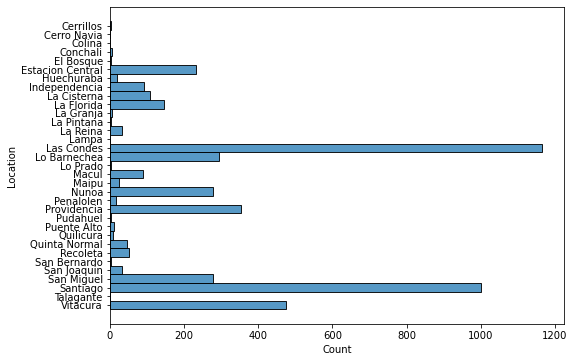

In [22]:
nrows, ncols = 1, 1

fig = plt.figure(figsize=(7.*ncols, 5.*nrows))
plt.subplots_adjust(wspace=.2, hspace=.2, bottom=0, left=0)
ax = []

ax = fig.add_subplot(nrows, ncols, 1)
sns.histplot(data=df6.sort_values(by=['Location'], ascending=True), y="Location")

### Renting Price (CLP)

Finally, let's examine *Price* feature values, which represent the renting apartment prices in CLP (Chilean pesos).

(1.0, 10000000.0)

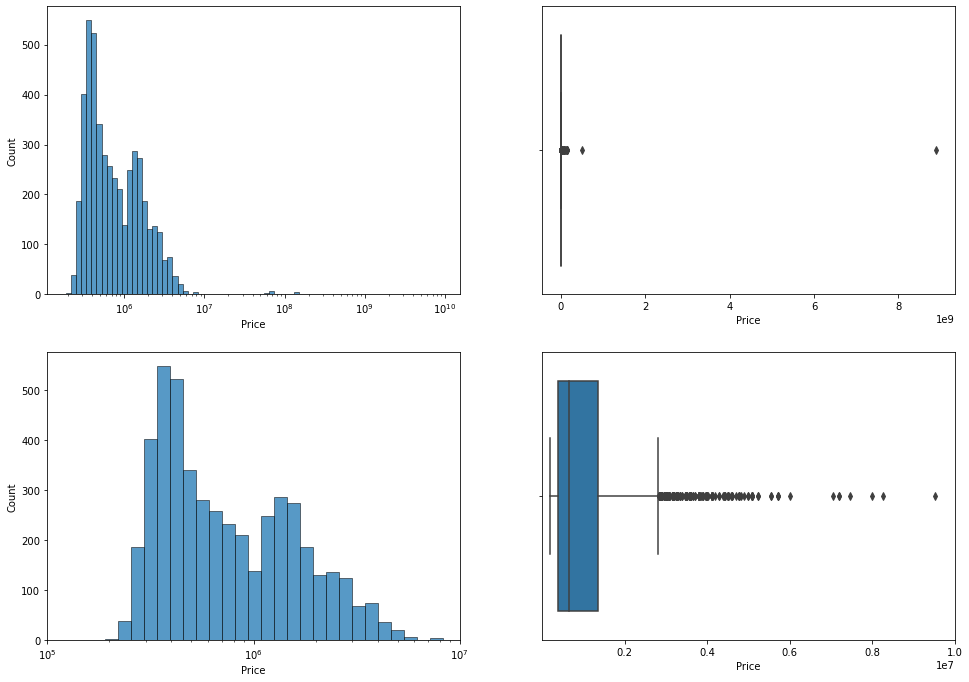

In [23]:
nrows, ncols = 2, 2

fig = plt.figure(figsize=(7.*ncols, 5.*nrows))
plt.subplots_adjust(wspace=.2, hspace=.2, bottom=0, left=0)
ax = []

ax = fig.add_subplot(nrows, ncols, 1)
sns.histplot(data=df6, x="Price", log_scale=True)

ax = fig.add_subplot(nrows, ncols, 2)
sns.boxplot(x=df6["Price"])

ax = fig.add_subplot(nrows, ncols, 3)
sns.histplot(data=df6, x="Price", log_scale=True)
ax.set_xlim(1e5, 1e7)

ax = fig.add_subplot(nrows, ncols, 4)
sns.boxplot(x=df6["Price"])
ax.set_xlim(1, 1e7)

In [24]:
df7 = df6[df6["Price"] >= 1e7]
print(df7.shape)
df7 = df7.sort_values(by=['Bedrooms'], ascending=False)
df7

(19, 8)


,Surface_total,Surface_usable,Bedrooms,Bathrooms,Location,URL,Price,Surface_difference
4476,955.0,460.0,5.0,7.0,Vitacura,https://www.portalinmobiliario.com/MLC-9564554...,1.009527e+07,495.0
2498,80.0,80.0,4.0,2.0,Nunoa,https://www.portalinmobiliario.com/MLC-9782859...,1.500000e+08,0.0
2931,50.0,50.0,3.0,1.0,Quinta Normal,https://www.portalinmobiliario.com/MLC-9786673...,7.179085e+07,0.0
4327,78.0,76.0,3.0,2.0,Santiago,https://www.portalinmobiliario.com/MLC-9769456...,1.381500e+08,2.0
3943,45.0,45.0,3.0,1.0,Santiago,https://www.portalinmobiliario.com/MLC-9552407...,6.507958e+07,0.0
2108,62.0,59.0,3.0,2.0,Lo Barnechea,https://www.portalinmobiliario.com/MLC-9732341...,1.492069e+08,3.0
430,54.0,54.0,3.0,1.0,La Cisterna,https://www.portalinmobiliario.com/MLC-9673350...,6.984151e+07,0.0
3895,61.0,61.0,2.0,2.0,Santiago,https://www.portalinmobiliario.com/MLC-9538890...,1.263496e+08,0.0
317,48.0,48.0,2.0,1.0,Independencia,https://www.portalinmobiliario.com/MLC-9630180...,8.412728e+07,0.0
3127,517.0,49.0,2.0,2.0,San Miguel,https://www.portalinmobiliario.com/MLC-9794709...,4.900000e+08,468.0


In [25]:
for j, i in enumerate(df7.index.values):
    print(f"{j+1}: {df7.loc[i, 'URL']}")

1: https://www.portalinmobiliario.com/MLC-956455455-exclusivo-departamento-amoblado-condominio-santa-anita-_JM#position=7&search_layout=stack&type=item&tracking_id=eb9f6c75-de8a-4ab0-89c2-7362e316462e
2: https://www.portalinmobiliario.com/MLC-978285916-se-vende-amplio-departamento-en-nunoa-_JM#position=19&search_layout=stack&type=item&tracking_id=6de4a6d5-2c07-4e0f-8b59-1d40448a5a34
3: https://www.portalinmobiliario.com/MLC-978667313-hermoso-departamento-para-invertir-_JM#position=19&search_layout=stack&type=item&tracking_id=ecfd43cc-3a85-4ca4-afc0-edb4def5276d
4: https://www.portalinmobiliario.com/MLC-976945692-departamento-en-venta-marin-con-san-isidro-_JM#position=46&search_layout=stack&type=item&tracking_id=bf9ff5d4-5358-43d2-9fc1-e88c3607f5d7
5: https://www.portalinmobiliario.com/MLC-955240785-barrio-yungay-maipu-san-pablo-_JM#position=22&search_layout=stack&type=item&tracking_id=32c83e98-a172-4a53-b50e-4ff59daff11c
6: https://www.portalinmobiliario.com/MLC-973234185-buen-departam

Based on the dataframe and plots above, there seem to be 19 listings with unrealistic high *Price* (>10,000,000 CLP). Considering the values reported for the remaining listing features (*Surface_usable*, *Bedrooms*, *Bathrooms*), and after exploring the listings URLs, only the first of the listing above seems to have data correctly reported (*Surface_usable* = 460.0, *Bedrooms* = 5, *Bathrooms* = 7). Hence, we will only keep this data point and remove the remaining data shown in the list. 

In [26]:
df8 = df6[(df6["Price"] < 1e7) | ((df6["Price"] >= 1e7) & (df6["Bedrooms"] > 4))]
print(df8.shape)
df8 = df8.sort_values(by=['Price'], ascending=False)
df8.head(20)

(4762, 8)


,Surface_total,Surface_usable,Bedrooms,Bathrooms,Location,URL,Price,Surface_difference
4476,955.0,460.0,5.0,7.0,Vitacura,https://www.portalinmobiliario.com/MLC-9564554...,10095271.0,495.0
2051,550.0,500.0,4.0,3.0,Lo Barnechea,https://www.portalinmobiliario.com/MLC-9678646...,9523842.0,50.0
2004,689.0,354.0,3.0,4.0,Lo Barnechea,https://www.portalinmobiliario.com/MLC-9699760...,8253997.0,335.0
1938,1758.0,600.0,6.0,6.0,Lo Barnechea,https://www.portalinmobiliario.com/MLC-9365324...,8000000.0,1158.0
2040,670.0,450.0,5.0,6.0,Lo Barnechea,https://www.portalinmobiliario.com/MLC-9743843...,7460343.0,220.0
1985,600.0,402.0,5.0,5.0,Lo Barnechea,https://www.portalinmobiliario.com/MLC-9373971...,7206374.0,198.0
2065,658.0,402.0,5.0,6.0,Lo Barnechea,https://www.portalinmobiliario.com/MLC-9680108...,7206374.0,256.0
1179,199.0,126.0,4.0,4.0,Las Condes,https://www.portalinmobiliario.com/MLC-9568242...,7047643.0,73.0
1117,650.0,575.0,4.0,5.0,Las Condes,https://www.portalinmobiliario.com/MLC-9556514...,6000000.0,75.0
1251,961.0,412.0,5.0,6.0,Las Condes,https://www.portalinmobiliario.com/arriendo/de...,5714305.0,549.0


### Regression fits (for most common locations)

In order to examine how the predictor features are related to the target feature (*Price*), we will plot regression fits between them across the most common locations.

In [27]:
locations_plot = df8.Location.value_counts(ascending=False)
locations_plot = locations_plot[locations_plot > 50]
print(len(locations_plot))
locations_plot

13


Las Condes          1163
Santiago             993
Vitacura             474
Providencia          353
Lo Barnechea         293
Nunoa                276
San Miguel           275
Estacion Central     232
La Florida           146
La Cisterna          107
Independencia         91
Macul                 88
Recoleta              52
Name: Location, dtype: int64

In [28]:
locations_plot = locations_plot[:7]
locations_plot

Las Condes      1163
Santiago         993
Vitacura         474
Providencia      353
Lo Barnechea     293
Nunoa            276
San Miguel       275
Name: Location, dtype: int64

In [29]:
locations_plot.sum()

3827

In [30]:
df9 = df8.copy()
df9["Location_plot"] = df8.Location.apply(lambda x: x if x in locations_plot else 'Other')
df9["Rooms"] = df8.apply(lambda x: x.Bedrooms + x.Bathrooms, axis=1)

df9 = df9.sort_values(by=['Location_plot'], ascending=True)
# df9 = df9[df9["Location_plot"] != "Other"]
print(df9.shape)
df9.head()

(4762, 10)


,Surface_total,Surface_usable,Bedrooms,Bathrooms,Location,URL,Price,Surface_difference,Location_plot,Rooms
1816,21.0,21.0,1.0,1.0,Las Condes,https://www.portalinmobiliario.com/MLC-9769611...,190000.0,0.0,Las Condes,2.0
1157,40.0,40.0,1.0,1.0,Las Condes,https://www.portalinmobiliario.com/arriendo/de...,507938.0,0.0,Las Condes,2.0
1333,220.0,220.0,4.0,4.0,Las Condes,https://www.portalinmobiliario.com/MLC-9685015...,1500000.0,0.0,Las Condes,8.0
1343,220.0,140.0,4.0,4.0,Las Condes,https://www.portalinmobiliario.com/MLC-9731724...,1500000.0,80.0,Las Condes,8.0
1292,160.0,140.0,4.0,3.0,Las Condes,https://www.portalinmobiliario.com/MLC-9716839...,1500000.0,20.0,Las Condes,7.0


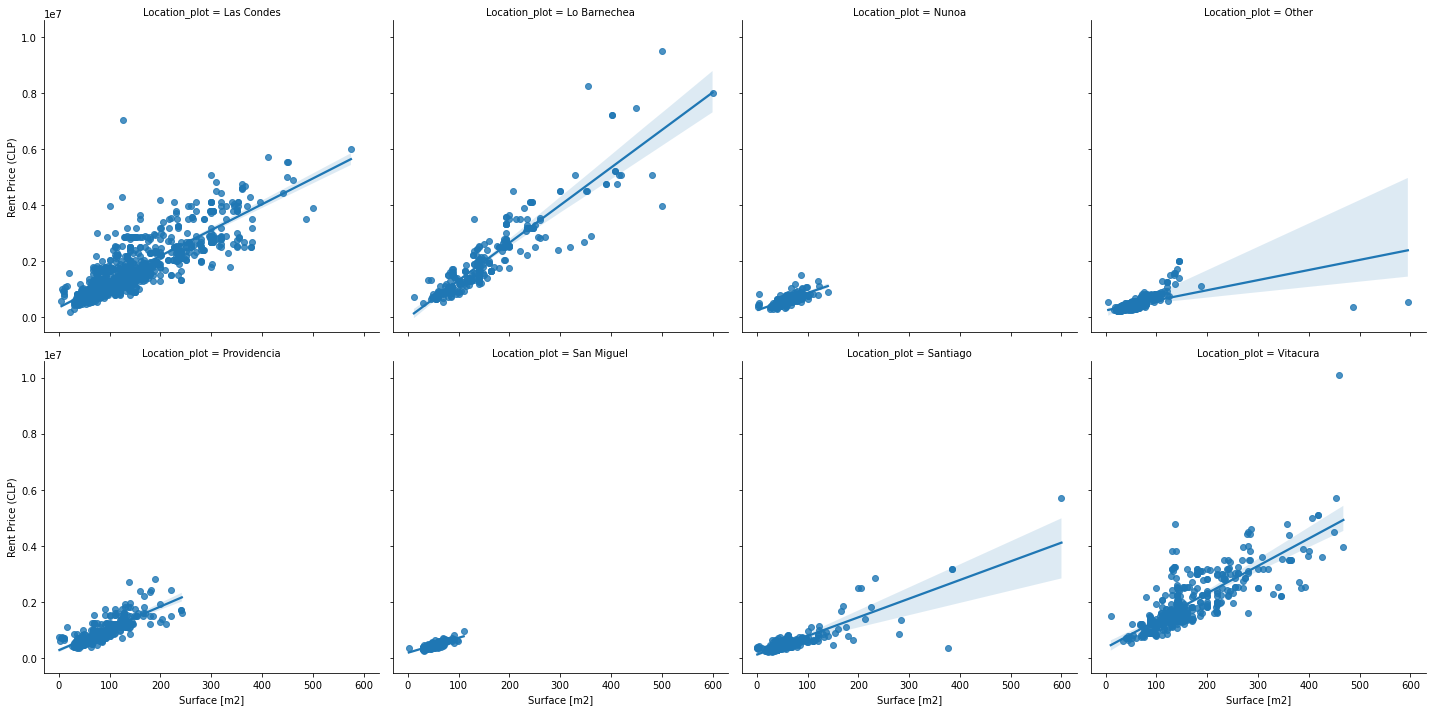

In [31]:
matplotlib.rcParams["figure.figsize"] = 12., 10

g = sns.lmplot(
    data=df9,
    x="Surface_usable", y="Price", col="Location_plot", col_wrap=4,
    height=5
)
g.set_axis_labels("Surface [m2]", "Rent Price (CLP)")

From the regression plots above, we observe that *Surface_usable* values show a linear relationship with *Price* values for the most common as well as the less common locations (*Location_plot* = Other). 

The slope on this linear relationship represents the rent price per square meter (*psm*) in the different locations, a commonly used metric in real estate business.
Below, we calculate the mean *psm* for each *Location*.

In [32]:
df9["Price_sqm"] = df9.apply(lambda x: x.Price / x.Surface_usable, axis=1)

print(df9.shape)
df9.head()

(4762, 11)


,Surface_total,Surface_usable,Bedrooms,Bathrooms,Location,URL,Price,Surface_difference,Location_plot,Rooms,Price_sqm
1816,21.0,21.0,1.0,1.0,Las Condes,https://www.portalinmobiliario.com/MLC-9769611...,190000.0,0.0,Las Condes,2.0,9047.619048
1157,40.0,40.0,1.0,1.0,Las Condes,https://www.portalinmobiliario.com/arriendo/de...,507938.0,0.0,Las Condes,2.0,12698.450000
1333,220.0,220.0,4.0,4.0,Las Condes,https://www.portalinmobiliario.com/MLC-9685015...,1500000.0,0.0,Las Condes,8.0,6818.181818
1343,220.0,140.0,4.0,4.0,Las Condes,https://www.portalinmobiliario.com/MLC-9731724...,1500000.0,80.0,Las Condes,8.0,10714.285714
1292,160.0,140.0,4.0,3.0,Las Condes,https://www.portalinmobiliario.com/MLC-9716839...,1500000.0,20.0,Las Condes,7.0,10714.285714


In [33]:
mean_price_sqm = df9.groupby(['Location'])['Price_sqm'].mean()
mean_price_sqm.sort_values(ascending=False)

Location
Providencia         15350.113095
Lo Barnechea        13462.962150
Las Condes          13261.137886
Nunoa               12807.860079
Vitacura            12639.056307
Santiago            11054.048444
Macul               10292.343943
La Reina            10083.075497
San Miguel           9913.433647
San Joaquin          9906.130217
Colina               8994.741667
La Florida           8979.252697
Estacion Central     8966.734517
Huechuraba           8831.026175
Lampa                8727.272727
La Cisterna          8662.351182
Independencia        8653.184313
Lo Prado             8593.750000
Recoleta             8585.810479
Penalolen            8508.959891
Maipu                8304.466537
Quinta Normal        8186.590757
Quilicura            8019.866803
Cerro Navia          7894.736842
La Granja            7794.054091
Conchali             7486.549799
Puente Alto          7250.972053
Talagante            6888.888889
El Bosque            6722.883598
La Pintana           6661.490683
C

We see a similar linear relationship between *Rooms* (*Bedrooms + Bathrooms*) and *Price* values from the regression plots below, although it is not as clear as for *Surface_usable* values.

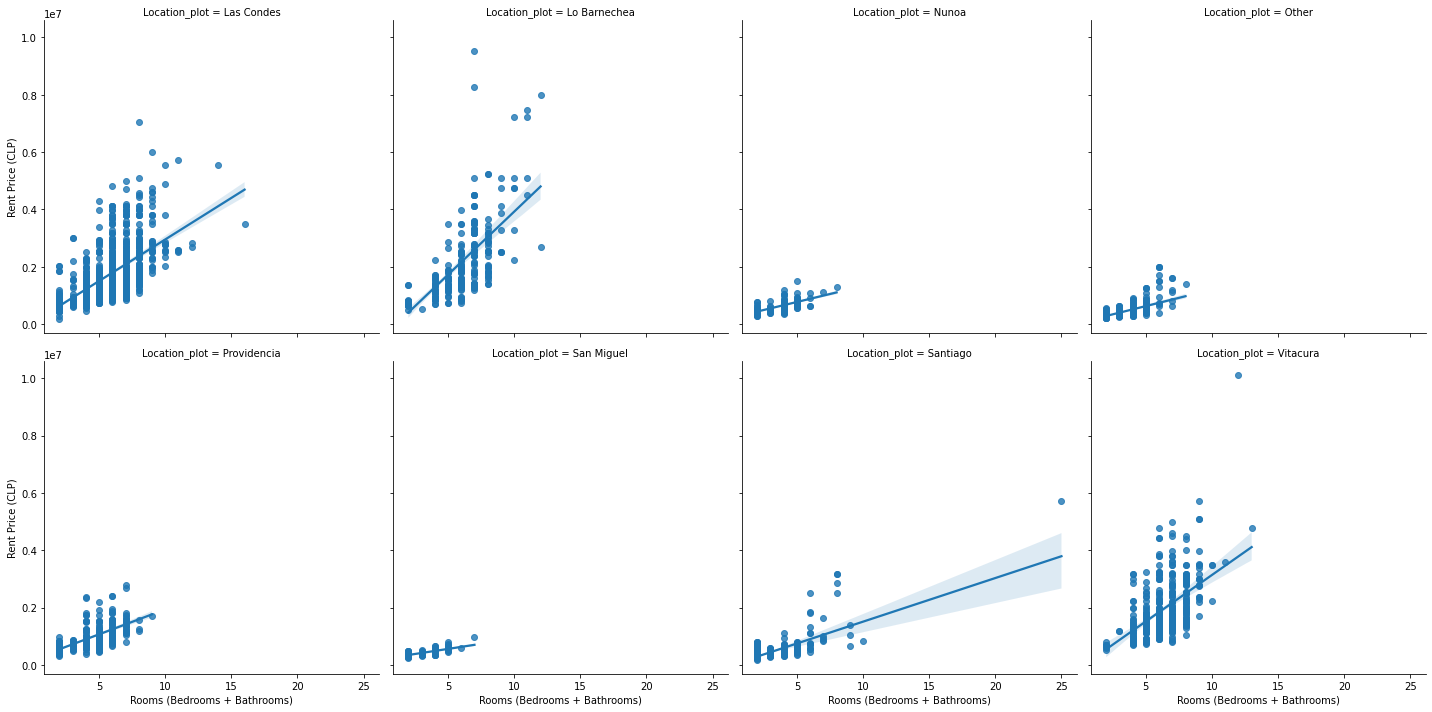

In [34]:
matplotlib.rcParams["figure.figsize"] = 12., 10

g = sns.lmplot(
    data=df9,
    x="Rooms", y="Price", col="Location_plot", col_wrap=4,
    height=5
)
g.set_axis_labels("Rooms (Bedrooms + Bathrooms)", "Rent Price (CLP)")

### Save dataset

After performing EDA, we remove the features that we will not consider for the analysis and save the dataset for later use.

In [35]:
features_drop = ['Surface_total','URL','Surface_difference','Location_plot','Rooms','Price_sqm']
df10 = df9.drop(features_drop, axis='columns')
df10 = df10.rename(columns={"Surface_usable": "Surface"})

print(df10.shape)
df10

(4762, 5)


,Surface,Bedrooms,Bathrooms,Location,Price
1816,21.0,1.0,1.0,Las Condes,190000.0
1157,40.0,1.0,1.0,Las Condes,507938.0
1333,220.0,4.0,4.0,Las Condes,1500000.0
1343,140.0,4.0,4.0,Las Condes,1500000.0
1292,140.0,4.0,3.0,Las Condes,1500000.0
...,...,...,...,...,...
4786,140.0,3.0,3.0,Vitacura,1550000.0
4345,144.0,4.0,4.0,Vitacura,1550000.0
4731,140.0,4.0,4.0,Vitacura,1550000.0
4407,185.0,3.0,3.0,Vitacura,2000000.0


In [36]:
df10.to_csv("RENT_APARTMENT_RM_eda.csv", index=False)